<a href="https://colab.research.google.com/github/MilianAlba/DMML2_CA/blob/main/DMML2_project_grayscale_pepper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data_dir = "../input/plantvillage-dataset/color"
data_dir = "/content/drive/MyDrive/grayscale_pepper/"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)


Found 2475 files belonging to 2 classes.
Using 1980 files for training.
Found 2475 files belonging to 2 classes.
Using 495 files for validation.


In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Pepper,_bell___Bacterial_spot
2.  Pepper,_bell___healthy


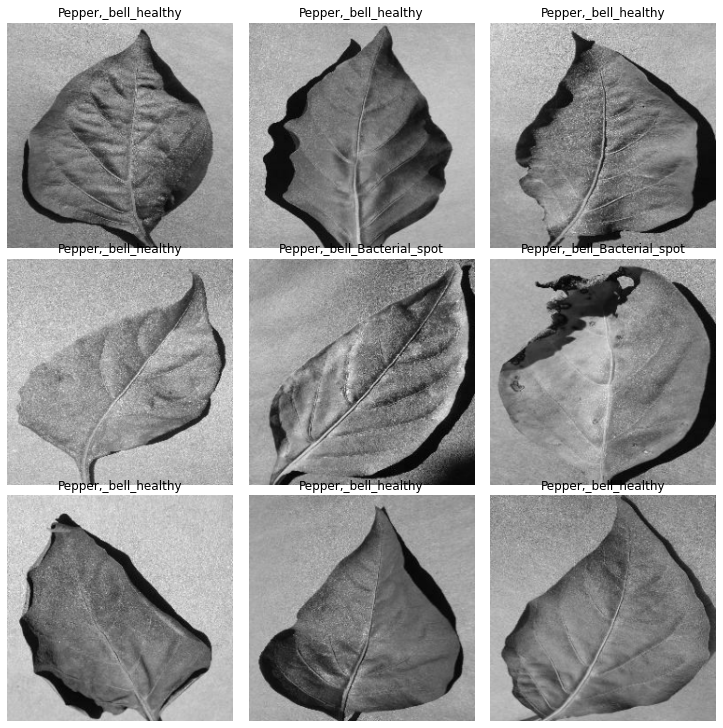

In [ ]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

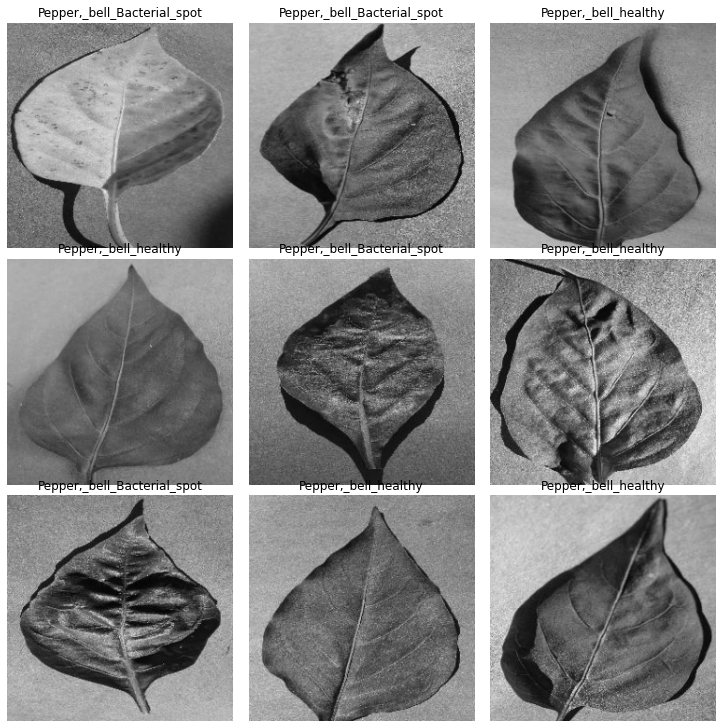

In [ ]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_batches_outdoor = tf.data.experimental.cardinality(test_dataset_outdoor)

test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 13
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomCrop(200, 200),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.4),
  #tf.keras.layers.experimental.preprocessing.Resizing(50, 50),
  #tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),

])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


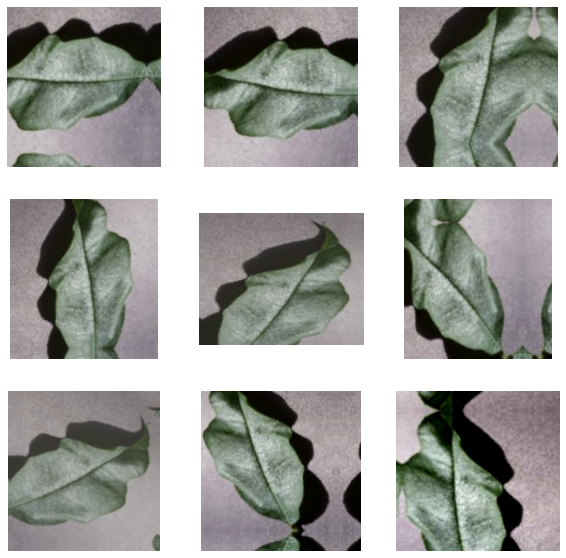

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
augmented_image

<tf.Tensor: shape=(1, 201, 205, 3), dtype=float32, numpy=
array([[[[209.77948 , 196.97498 , 203.67    ],
         [210.1924  , 197.3879  , 204.08292 ],
         [212.59991 , 199.79541 , 206.49043 ],
         ...,
         [122.633835, 107.03395 , 115.12666 ],
         [127.74944 , 112.14955 , 120.24226 ],
         [131.82639 , 116.22649 , 124.3192  ]],

        [[210.44354 , 197.639   , 204.33403 ],
         [210.45598 , 197.65149 , 204.3465  ],
         [213.29988 , 200.49539 , 207.19038 ],
         ...,
         [129.66951 , 114.069626, 122.16234 ],
         [132.58665 , 116.98674 , 125.07945 ],
         [134.19939 , 118.59951 , 126.69223 ]],

        [[210.6824  , 197.8779  , 204.57292 ],
         [211.3768  , 198.57228 , 205.2673  ],
         [213.33214 , 200.52765 , 207.22269 ],
         ...,
         [133.30045 , 117.700554, 125.79326 ],
         [131.56972 , 115.96986 , 124.06256 ],
         [132.42398 , 116.82411 , 124.916824]],

        ...,

        [[187.20589 , 173.0037  , 

In [ ]:
first_image

<tf.Tensor: shape=(240, 240, 3), dtype=float32, numpy=
array([[[130.9789  , 119.97888 , 123.97888 ],
        [ 97.933334,  86.933334,  90.933334],
        [115.05556 , 104.05556 , 108.05556 ],
        ...,
        [143.76114 , 134.76114 , 139.76114 ],
        [141.51997 , 132.51997 , 137.51997 ],
        [129.69768 , 120.69768 , 125.69768 ]],

       [[132.56667 , 121.56666 , 125.566666],
        [109.76    ,  98.76    , 102.76    ],
        [100.98334 ,  89.98334 ,  93.98334 ],
        ...,
        [145.98337 , 136.98337 , 141.98337 ],
        [147.67001 , 138.67001 , 143.67001 ],
        [138.51993 , 129.51993 , 134.51993 ]],

       [[104.77778 ,  93.77778 ,  97.77778 ],
        [106.05    ,  95.05    ,  99.05    ],
        [ 92.5     ,  81.5     ,  85.5     ],
        ...,
        [139.88893 , 130.88893 , 135.88893 ],
        [144.40004 , 135.40004 , 140.40004 ],
        [139.51662 , 130.51662 , 135.51662 ]],

       ...,

       [[118.689064, 111.689064, 119.689064],
        [108.

In [ ]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1536)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(240, 240, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 1

In [ ]:
len(train_dataset)

62

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 [==============================] - 692s 11s/step - loss: 0.6162 - tp: 1331.0000 - fp: 649.0000 - tn: 1331.0000 - fn: 649.0000 - accuracy: 0.6722 - precision: 0.6722 - recall: 0.6722 - auc: 0.7452 - val_loss: 0.3785 - val_tp: 331.0000 - val_fp: 68.0000 - val_tn: 331.0000 - val_fn: 68.0000 - val_accuracy: 0.8296 - val_precision: 0.8296 - val_recall: 0.8296 - val_auc: 0.9185


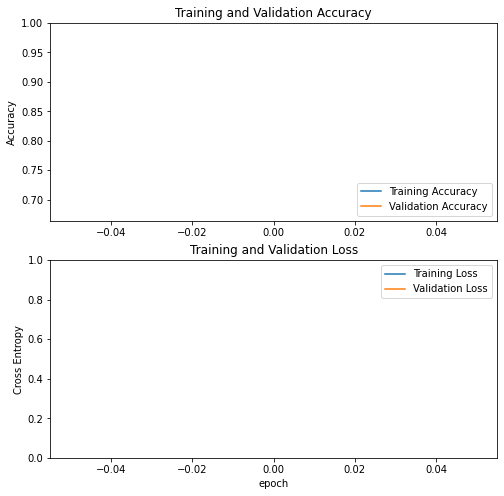

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

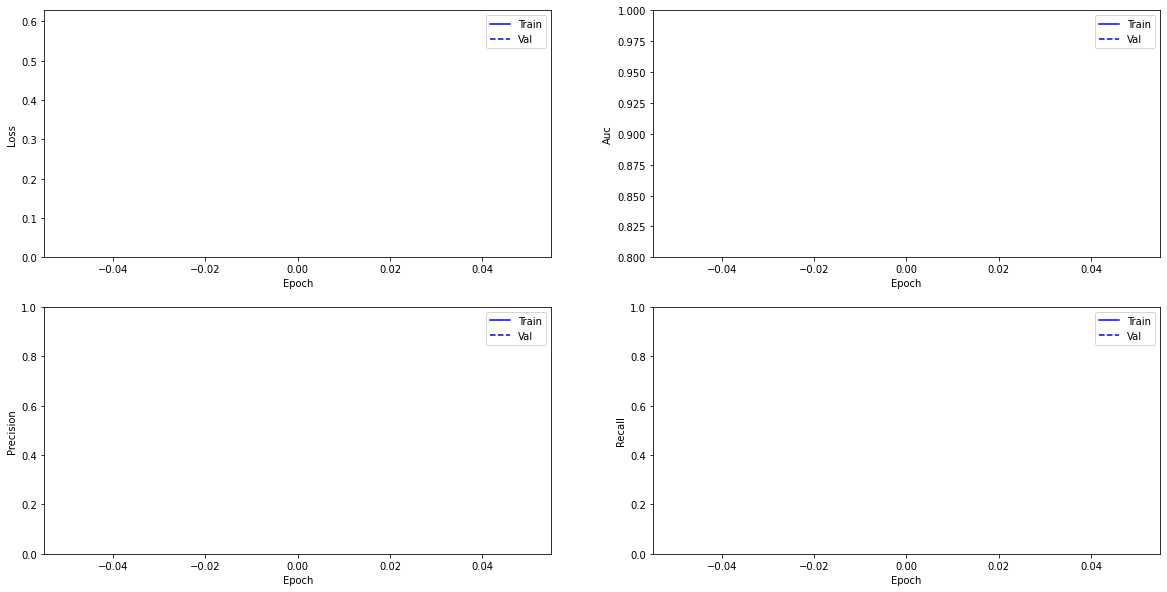

In [ ]:
plot_metrics(history)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

52

In [ ]:
#fine_tune_epochs = 15
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 [==============================] - 812s 13s/step - loss: 0.3183 - tp: 2040.0000 - fp: 339.0000 - tn: 2040.0000 - fn: 339.0000 - accuracy: 0.8575 - precision: 0.8575 - recall: 0.8575 - auc: 0.9351 - val_loss: 0.1841 - val_tp: 376.0000 - val_fp: 23.0000 - val_tn: 376.0000 - val_fn: 23.0000 - val_accuracy: 0.9424 - val_precision: 0.9424 - val_recall: 0.9424 - val_auc: 0.9810
Epoch 2/2
62/62 [==============================] - 792s 13s/step - loss: 0.1862 - tp: 1827.0000 - fp: 153.0000 - tn: 1827.0000 - fn: 153.0000 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9792 - val_loss: 0.1387 - val_tp: 379.0000 - val_fp: 20.0000 - val_tn: 379.0000 - val_fn: 20.0000 - val_accuracy: 0.9499 - val_precision: 0.9499 - val_recall: 0.9499 - val_auc: 0.9883


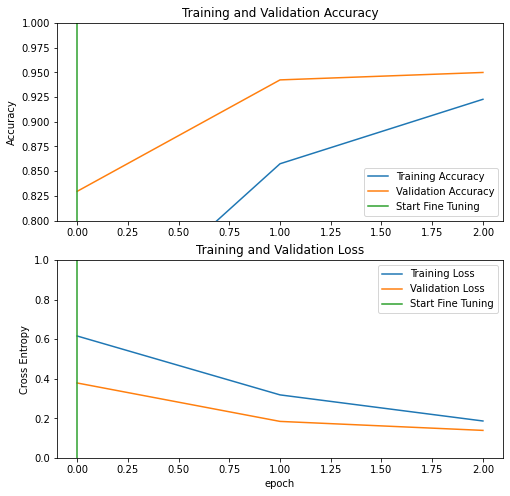

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

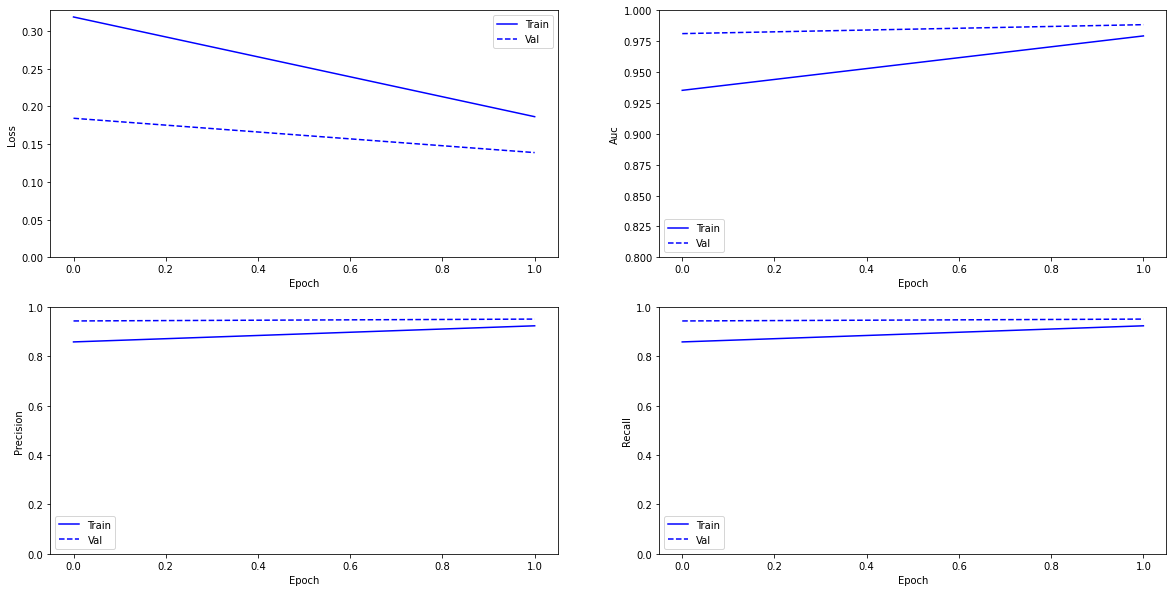

In [ ]:
plot_metrics(history_fine)

In [ ]:
result = model.evaluate(test_dataset)

3/3 [==============================] - 27s 9s/step - loss: 0.2088 - tp: 88.0000 - fp: 8.0000 - tn: 88.0000 - fn: 8.0000 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9728


In [ ]:
result = model.evaluate(validation_dataset)

13/13 [==============================] - 112s 9s/step - loss: 0.1501 - tp: 377.0000 - fp: 22.0000 - tn: 377.0000 - fn: 22.0000 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9858


In [ ]:
print(len(test_dataset))

2


In [ ]:
print(len(validation_dataset))

10


In [ ]:
print(len(train_dataset))

45


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.035
tp : 288.0
fp : 5.0
tn : 3511.0
fn : 5.0
accuracy : 0.983
precision : 0.983
recall : 0.983
auc : 1.0


Predictions:
 [3, 10, 10, 10, 4, 3, 4, 3, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 3, 10, 10, 3, 10, 10, 3]
Labels:
 [3, 10, 10, 10, 4, 3, 4, 3, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 4, 10, 10, 3, 10, 10, 3]


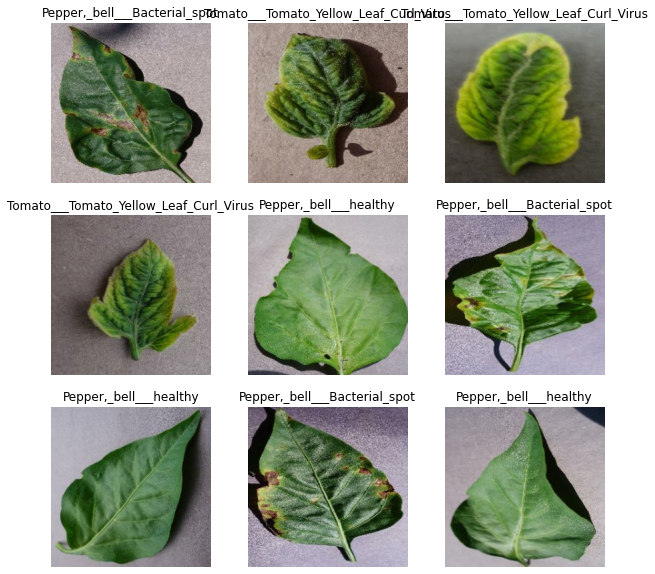

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./inception_v3")

INFO:tensorflow:Assets written to: ./inception_v3/assets


INFO:tensorflow:Assets written to: ./inception_v3/assets
